In [84]:
%config InlineBackend.figure_format = 'retina'

In [85]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from kspecdr.inst.isoplane import convert_isoplane_header, add_fiber_table
from kspecdr.io.image import ImageFile
from kspecdr.preproc.make_im import make_im
from kspecdr.tlm.make_tlm import read_instrument_data, make_tlm

WD = Path("/data1/hbahk/kspec/kspecdr")
RESOURCES = WD / "resources"
TESTDIR = RESOURCES / "isoplane_arctest_20251224"

hdul = fits.open(TESTDIR / "flat_150_490_1sec 2025-12-24.fits")
hdul.info()

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec 2025-12-24.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     171   (1340, 1300, 5)   int16 (rescales to uint16)   


In [86]:
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFFFF")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "flat_150_490_1sec_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

In [87]:
hdul.info()

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec 2025-12-24.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     186   (1340, 1300)   uint16   
  1  FIBRES        1 BinTableHDU     13   16R x 2C   ['1A', '20A']   


In [88]:
from astropy.table import Table

Table(hdul[1].data)

TYPE,NAME
str1,str20
P,Fiber 1
P,Fiber 2
P,Fiber 3
P,Fiber 4
P,Fiber 5
P,Fiber 6
P,Fiber 7
P,Fiber 8
P,Fiber 9


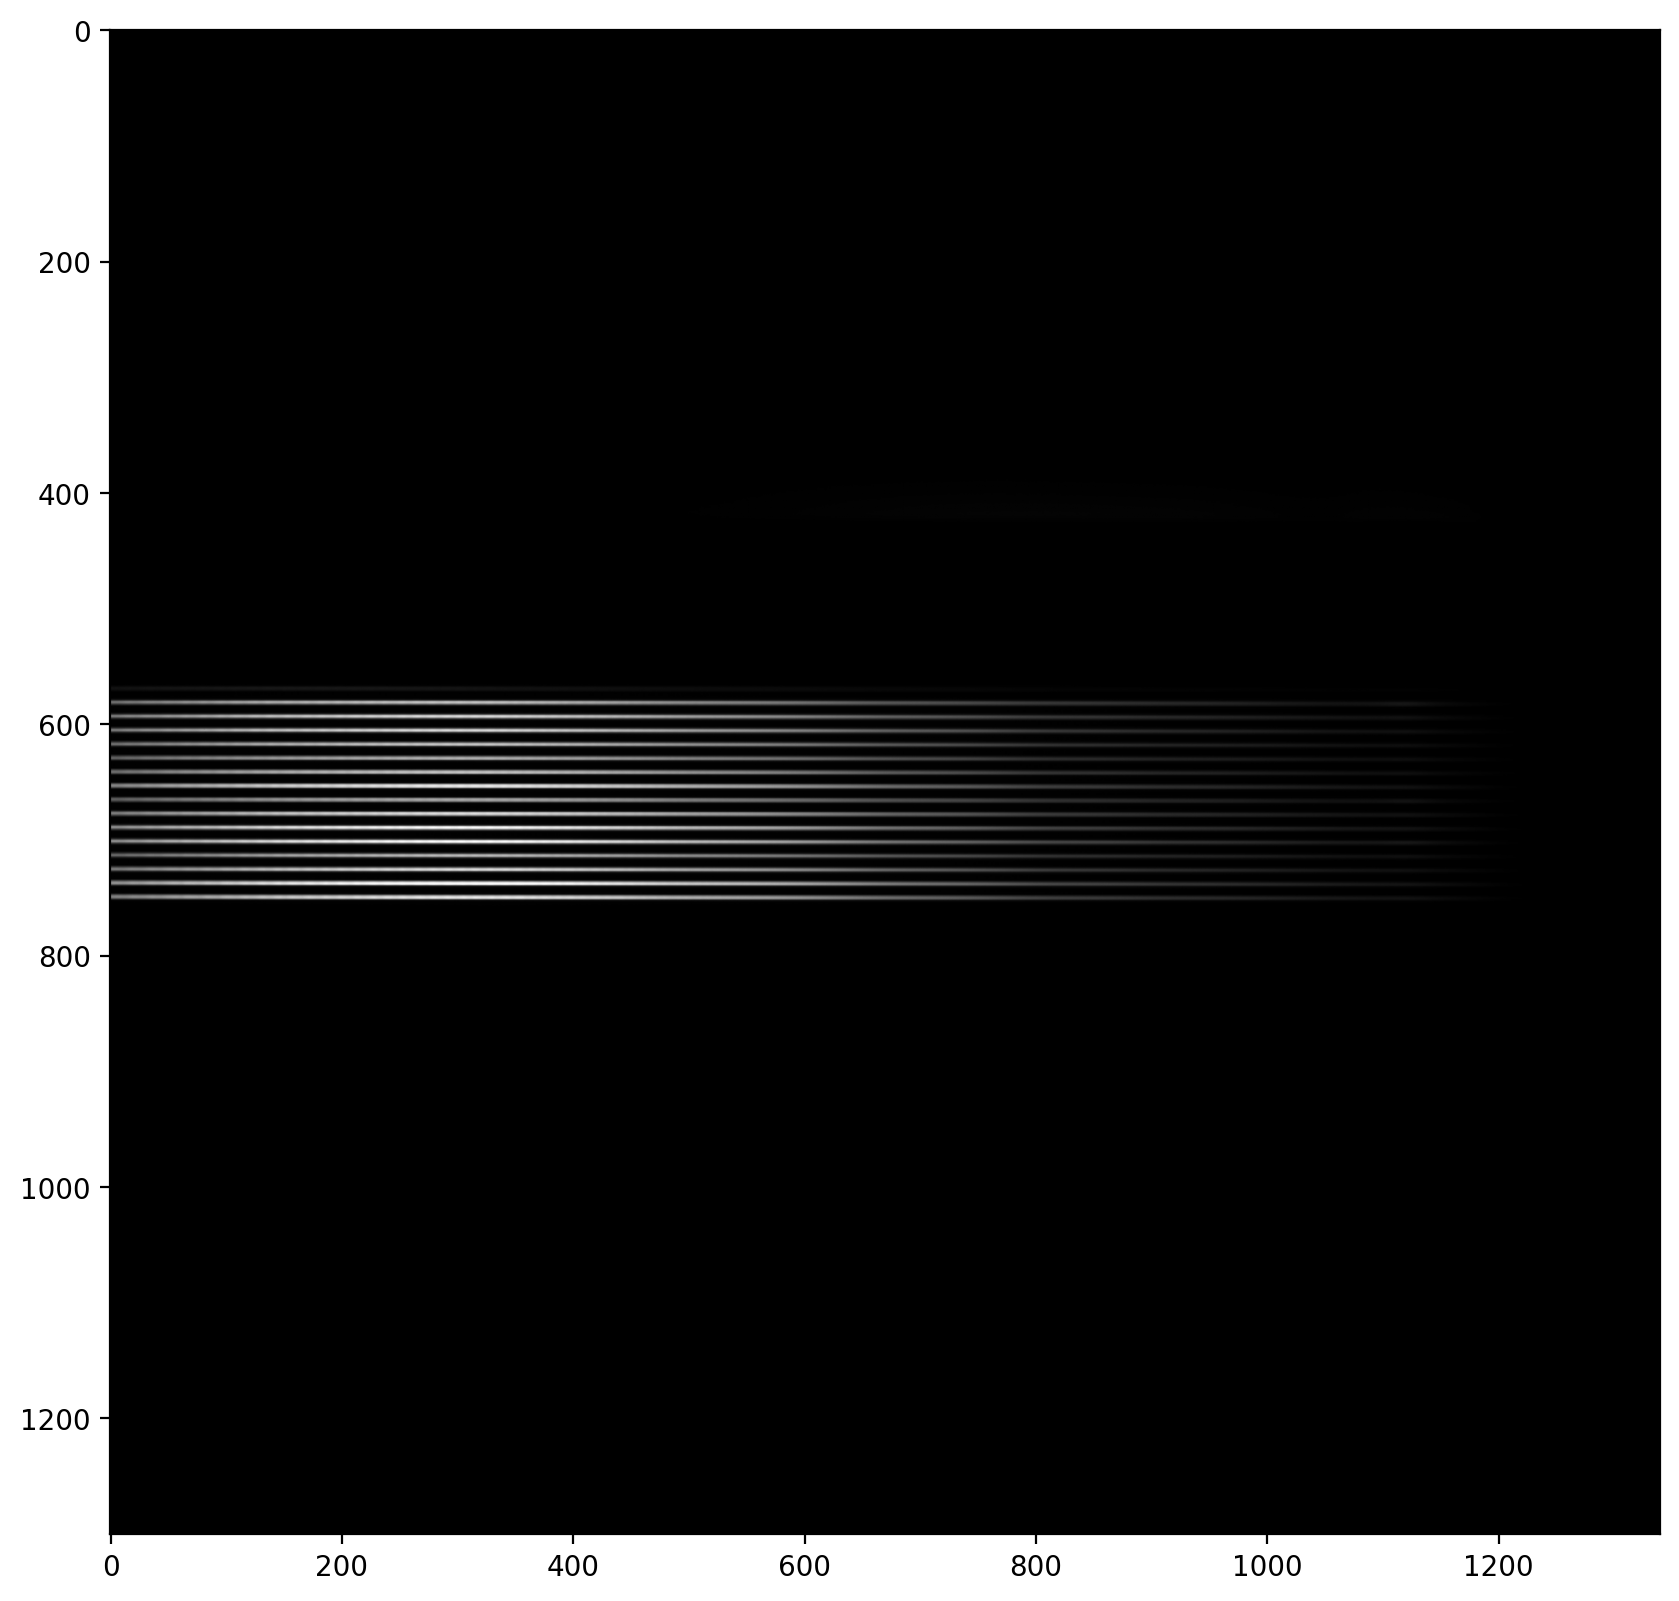

In [89]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(hdul[0].data, cmap="gray")
plt.show()

In [90]:
args = {"IMAGE_FILENAME": new_fpath.as_posix()}

im = ImageFile(new_fpath.as_posix(), mode='READ')
im.open()


make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (

INFO:kspecdr.preproc.make_im:Copying fiber table from source file
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: UPDATE)
INFO:kspecdr.io.image:Copied fiber table 'FIBRES' from source file
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits
INFO:kspecdr.preproc.make_im:Successfully created IM file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: UPDATE)
INFO:kspecdr.preproc.make_im:0.01% of pixels were saturated
INFO:kspecdr.preproc.make_im:No bias subtraction performed
INFO:kspecdr.preproc.make_i

'/data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits'

In [99]:
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix()}

im = ImageFile(fpath_im.as_posix(), mode='READ')
im.open()
img_data, var_data, fibre_types = read_instrument_data(im, 6)

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)


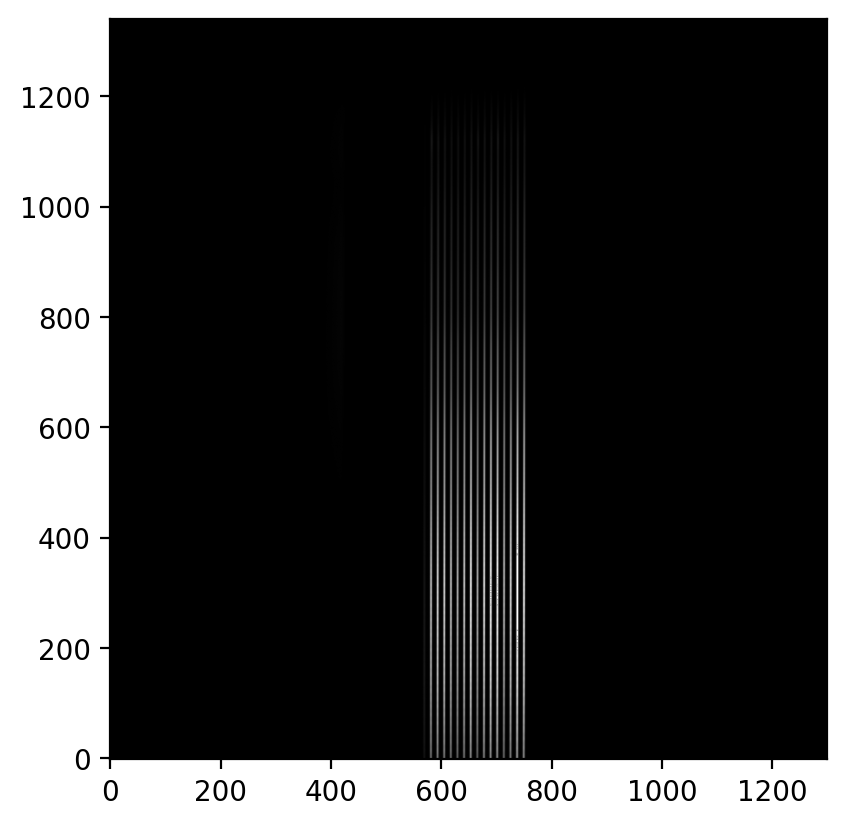

In [100]:
plt.imshow(img_data, cmap='gray', origin='lower')
plt.show()

In [101]:
im.get_instrument_code()

99

In [121]:
make_tlm(args)

INFO:kspecdr.tlm.make_tlm:Generating tramline map from /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)
INFO:kspecdr.tlm.make_tlm:Instrument code: 99
INFO:kspecdr.tlm.make_tlm:Starting tramline map generation for non-2DF instrument
INFO:kspecdr.tlm.make_tlm:Fibres officially in use: 16
INFO:kspecdr.tlm.make_tlm:Fibres potentially able: 0
INFO:kspecdr.tlm.make_tlm:Fibres officially dead: 0
INFO:kspecdr.tlm.make_tlm:Sweeping image for signs of fibre traces...
INFO:kspecdr.tlm.make_tlm:Processing column 0/1340 (0.0%)


INFO:kspecdr.tlm.make_tlm:Processing column 50/1340 (3.7%)
INFO:kspecdr.tlm.make_tlm:Processing column 100/1340 (7.5%)
INFO:kspecdr.tlm.make_tlm:Processing column 150/1340 (11.2%)
INFO:kspecdr.tlm.make_tlm:Processing column 200/1340 (14.9%)
INFO:kspecdr.tlm.make_tlm:Processing column 250/1340 (18.7%)
INFO:kspecdr.tlm.make_tlm:Processing column 300/1340 (22.4%)
INFO:kspecdr.tlm.make_tlm:Processing column 350/1340 (26.1%)
INFO:kspecdr.tlm.make_tlm:Processing column 400/1340 (29.9%)
INFO:kspecdr.tlm.make_tlm:Processing column 450/1340 (33.6%)
INFO:kspecdr.tlm.make_tlm:Processing column 500/1340 (37.3%)
INFO:kspecdr.tlm.make_tlm:Processing column 550/1340 (41.0%)
INFO:kspecdr.tlm.make_tlm:Processing column 600/1340 (44.8%)
INFO:kspecdr.tlm.make_tlm:Processing column 650/1340 (48.5%)
INFO:kspecdr.tlm.make_tlm:Processing column 700/1340 (52.2%)
INFO:kspecdr.tlm.make_tlm:Processing column 750/1340 (56.0%)
INFO:kspecdr.tlm.make_tlm:Processing column 800/1340 (59.7%)
INFO:kspecdr.tlm.make_tlm:P

In [122]:
fpath_tlm = new_fpath.parent / (new_fpath.stem + "_tlm.fits")

hdul = fits.open(fpath_tlm)
tlm_data = hdul[0].data
hdul.info()

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (1340, 16)   float64   
  1  WAVELA        1 ImageHDU         8   (1340, 16)   float64   


In [123]:
img_data.shape

(1340, 1300)

In [124]:
tlm_data

array([[581.09333333, 581.09224408, 581.09115826, ..., 582.70366562,
        582.70716718, 582.71067217],
       [593.09333333, 593.09224408, 593.09115826, ..., 594.70366562,
        594.70716718, 594.71067217],
       [605.04102564, 605.04025391, 605.03948522, ..., 606.71744776,
        606.72073026, 606.72401579],
       ...,
       [748.8608547 , 748.86135315, 748.86185275, ..., 750.54950905,
        750.55153778, 750.55356765],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]], shape=(16, 1340), dtype='>f8')

(0.0, 300.0)

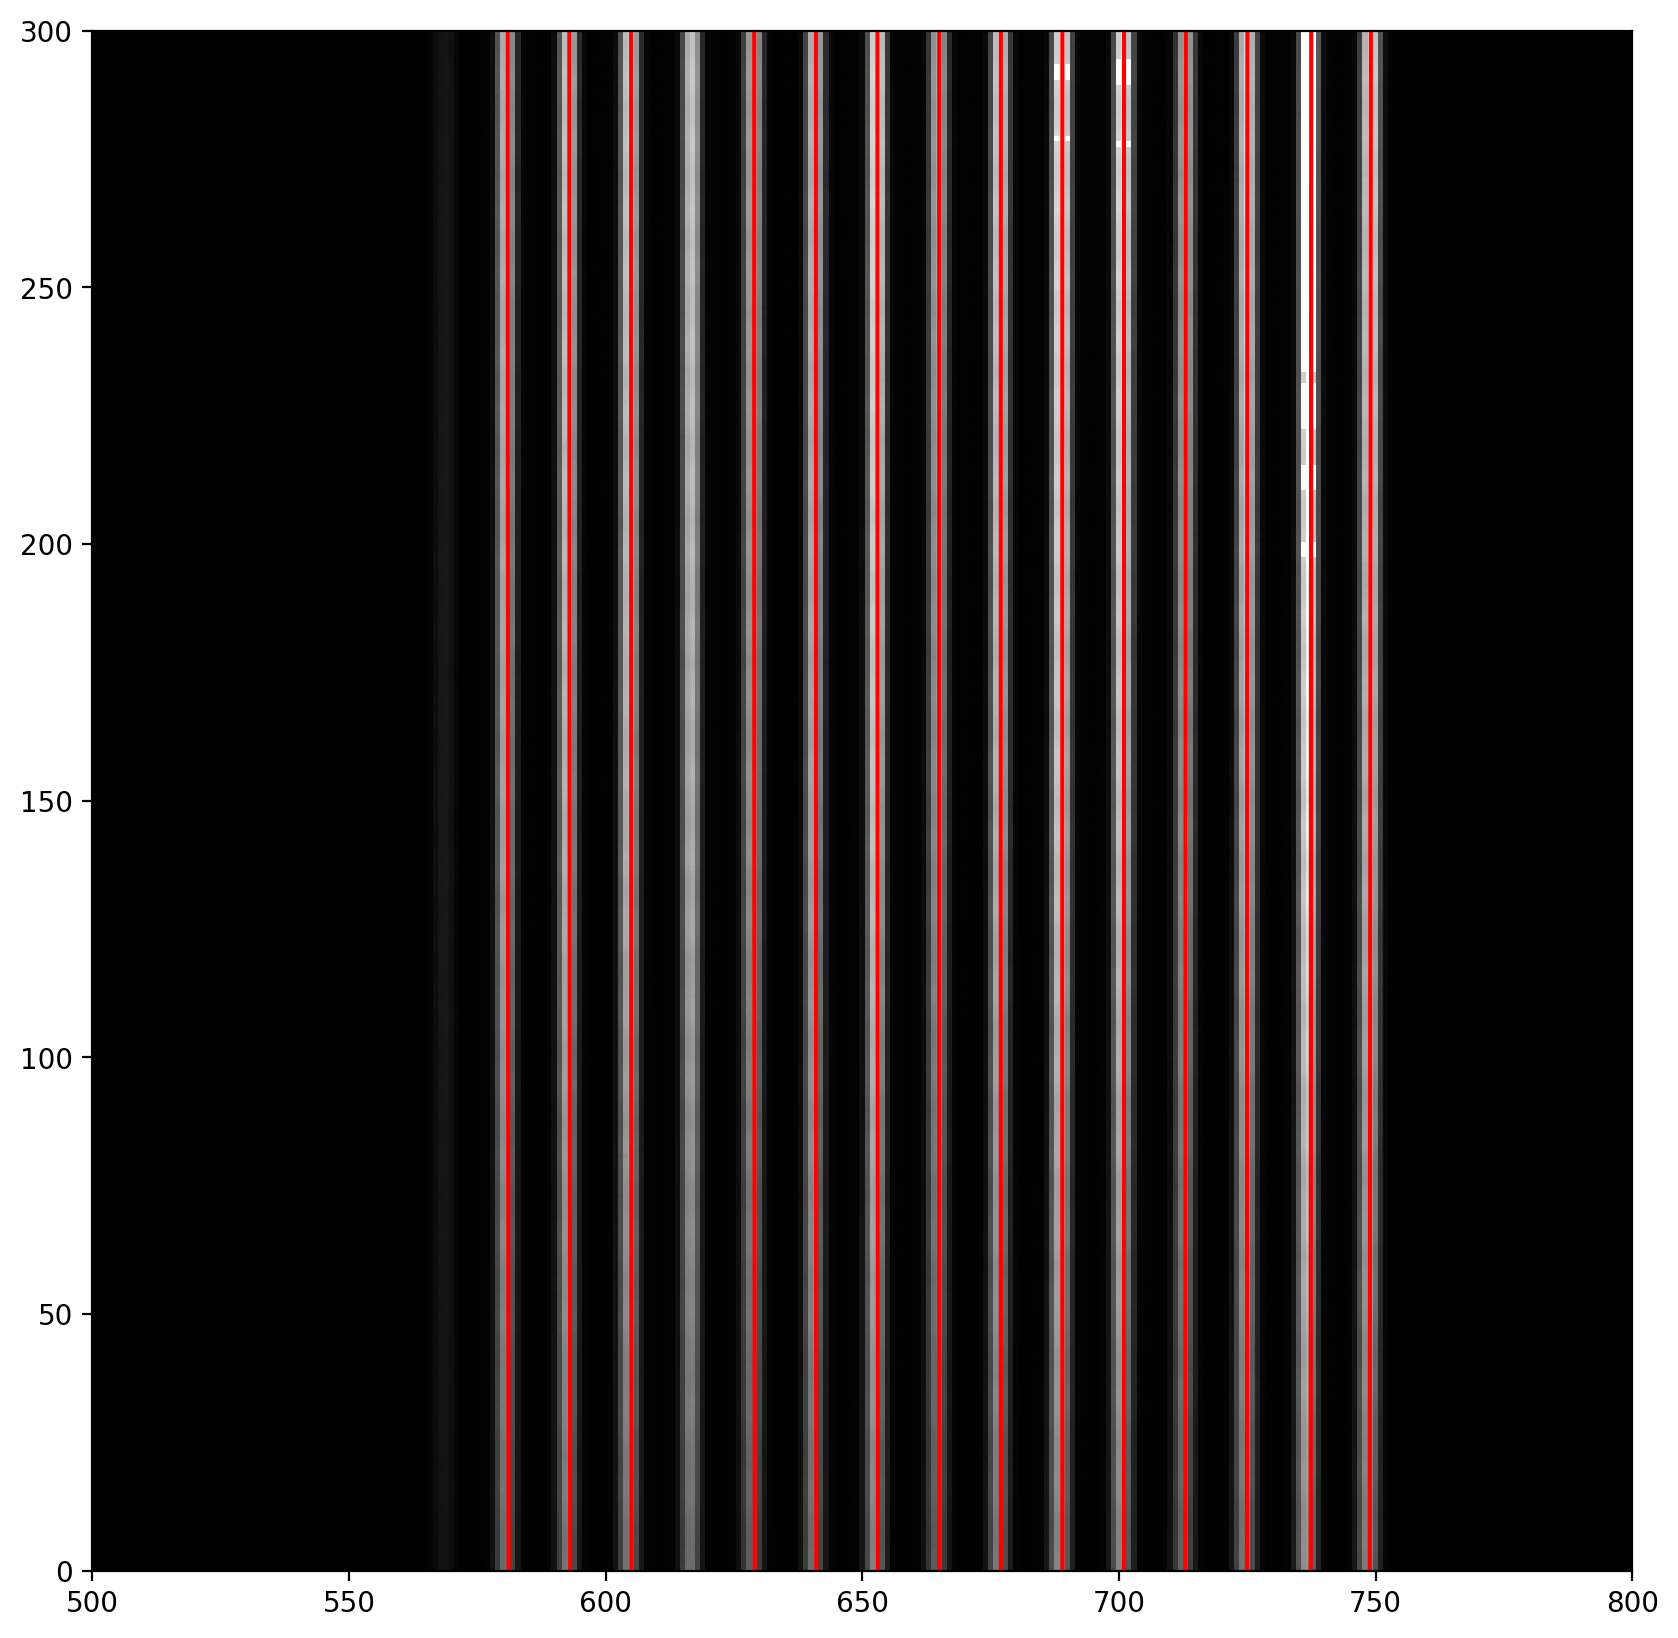

In [126]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap='gray', origin='lower')
for tl in tlm_data:
    ax.plot(tl, np.arange(tl.shape[0]), c="r")

ax.set_xlim(500, 800)
ax.set_ylim(0, 300)
